# RFM 분석(고객 행동 분석 기법)

In [ ]:
# R (Recency)  최근성 : 고객이 얼마나 최근에 구매했는가 : 최근에 구매한 고객일수록 충성도가 높다고 봄
# F (Frequency)	빈도 :	고객이 얼마나 자주 구매했는가	: 자주 방문/구매하는 고객일수록 핵심 고객
# M (Monetary)	금액 :	고객이 얼마나 많은 돈을 썼는가 :	총 지출이 많을수록 가치 높은 고객

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/전자상거래_영국 데이터/data.csv", encoding="latin1")

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [3]:
# 고객 기반 분석이라 고객을 구별할 수 있는 유일한 값이 고객ID라서 고객ID의 nan 값은 제거하도록 함
df.dropna(subset=['CustomerID'], inplace=True)

In [ ]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [4]:
# InvoiceNo에 C문자가 들어가 있는 경우는 반품처리임 / Quantity에도 -가 쓰여져있음
# 고객ID가 반품이 있을때 구매행과 반품행의 StockCode가 같고 Quantity의 sum이 0이면 그 두행 제외
df_반품 = df[df.groupby(['CustomerID', 'StockCode'])['Quantity'].transform('sum') != 0]
# 구매 이력은 없고 반품만 존재하는 행 제거
df_result = df_반품[~df_반품['InvoiceNo'].astype(str).str.contains('C', case=False, na=False)]

In [5]:
# 반품 전표가 남았는지
assert not df_result['InvoiceNo'].astype(str).str.startswith('C').any()

# 전량 반품 조합이 남았는지
chk = df_result.groupby(['CustomerID','StockCode'])['Quantity'].sum()
assert (chk != 0).all()


## R (Recency)

In [6]:
# R 을 구할때 기준일을 df['InvoiceDate'].max()의 다음날로 설정
df_result['InvoiceDate'] = pd.to_datetime(df_result['InvoiceDate'])
last_date = df_result['InvoiceDate'].max()
reference_date = (last_date.normalize() + pd.Timedelta(days=1))
print("기준일 :", reference_date)

기준일 : 2011-12-10 00:00:00


/tmp/ipython-input-441503516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['InvoiceDate'] = pd.to_datetime(df_result['InvoiceDate'])


In [7]:
# R 구하기(day)
rfm_r = df_result.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days
}).rename(columns={'InvoiceDate': 'Recency'})

print(rfm_r)

            Recency
CustomerID         
12347.0           2
12348.0          75
12349.0          18
12350.0         310
12352.0          36
...             ...
18280.0         277
18281.0         180
18282.0           7
18283.0           3
18287.0          42

[4327 rows x 1 columns]


## F (Frequency)

In [8]:
# 구매빈도
# 구매시점코드인 InvoiceNo 를 중복 제외 고유한 주문번호 개수를 구한다
rfm_f = df_result.groupby('CustomerID')['InvoiceNo'].nunique()

print(rfm_f)

CustomerID
12347.0     7
12348.0     4
12349.0     1
12350.0     1
12352.0     7
           ..
18280.0     1
18281.0     1
18282.0     2
18283.0    16
18287.0     3
Name: InvoiceNo, Length: 4327, dtype: int64


## M (Monetary)

In [9]:
# 금액 (구매수량*개당금액)
df_result['money'] = df_result['Quantity'] * df_result['UnitPrice']
rfm_m = df_result.groupby('CustomerID',as_index=False)['money'].sum()

print(rfm_m)

      CustomerID    money
0        12347.0  4310.00
1        12348.0  1797.24
2        12349.0  1757.55
3        12350.0   334.40
4        12352.0  1665.74
...          ...      ...
4322     18280.0   180.60
4323     18281.0    80.82
4324     18282.0   178.05
4325     18283.0  2094.88
4326     18287.0  1837.28

[4327 rows x 2 columns]


/tmp/ipython-input-2573738946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['money'] = df_result['Quantity'] * df_result['UnitPrice']


## 병합

In [10]:
# rfm_r,rfm_f,rfm_m 병합
rfm1 = pd.merge(rfm_r, rfm_f, on='CustomerID', how='inner')
rfm = pd.merge(rfm1, rfm_m, on='CustomerID', how='inner')
rfm.columns = ['CustomerID','Recency','Frequency','Monetary']

In [11]:
rfm

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,4310.00
1,12348.0,75,4,1797.24
2,12349.0,18,1,1757.55
3,12350.0,310,1,334.40
4,12352.0,36,7,1665.74
...,...,...,...,...
4322,18280.0,277,1,180.60
4323,18281.0,180,1,80.82
4324,18282.0,7,2,178.05
4325,18283.0,3,16,2094.88


## 등급화

In [12]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4327.000000,4327.00000,4327.000000,4327.000000
mean,15301.367691,92.08343,4.267622,1983.267161
std,1719.999392,100.03853,7.687555,8488.173432
min,12347.000000,0.00000,1.000000,0.000000
25%,13815.500000,17.00000,1.000000,306.290000
50%,15301.000000,50.00000,2.000000,665.860000
75%,16777.500000,142.00000,5.000000,1652.225000
max,18287.000000,373.00000,210.000000,280206.020000


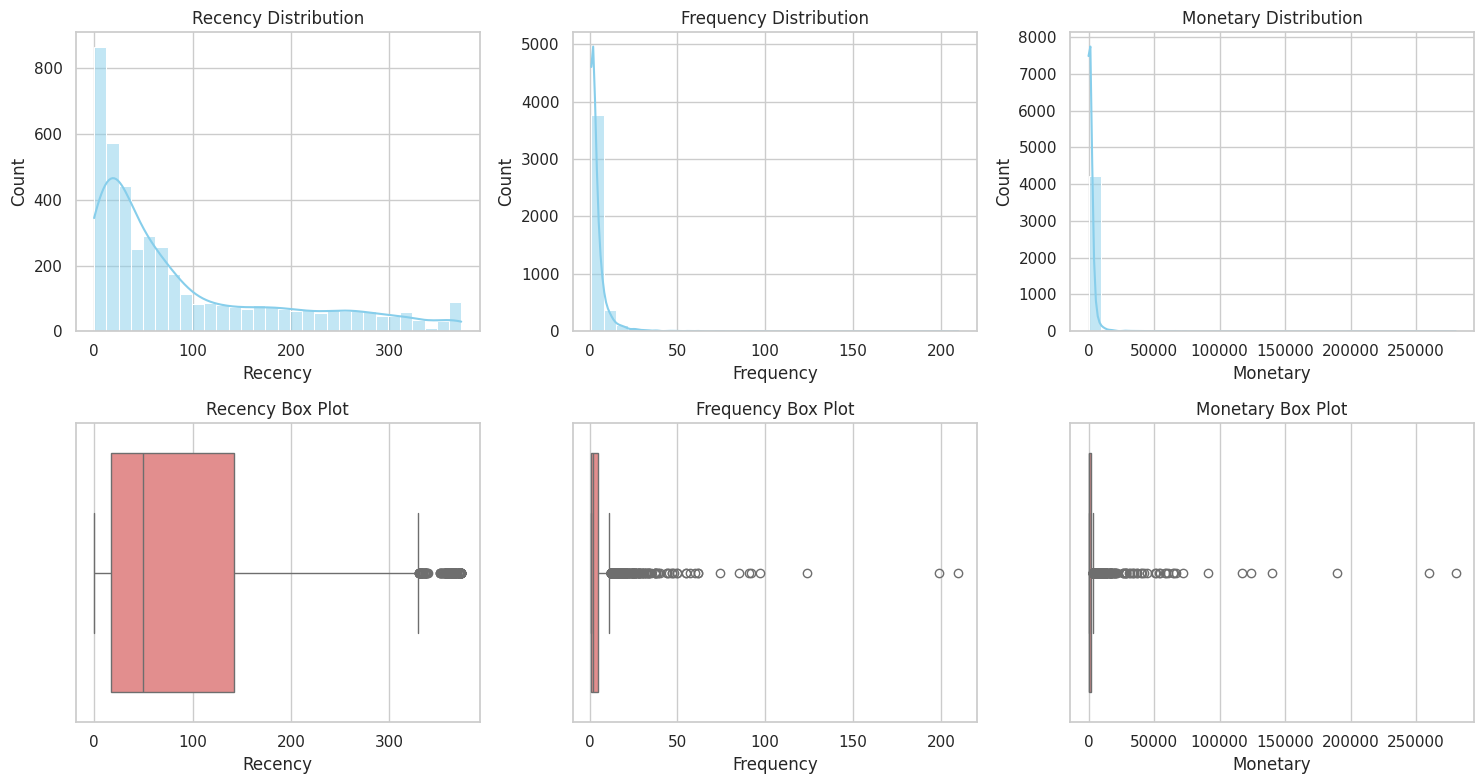

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 기본 시각화 스타일
sns.set(style='whitegrid')

# RFM 컬럼 목록
rfm_cols = ['Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(15, 8))

# 1️⃣ Distribution Plots
for i, col in enumerate(rfm_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(rfm[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} Distribution', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')

# 2️⃣ Box Plots
for i, col in enumerate(rfm_cols, 4):
    plt.subplot(2, 3, i)
    sns.boxplot(x=rfm[col], color='lightcoral')
    plt.title(f'{col} Box Plot', fontsize=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()




In [14]:
# 비교적 완만하면 세분화 필요, 극단적일수록 단순화 필요해보임
# Recency	오른쪽 꼬리, 완만함
# 5등급화

# Frequency	극단적 오른쪽 꼬리
# 4등급화

# Monetary	극단적 오른쪽 꼬리
# 4등급화

In [15]:
# Recency는 완만하니까 qcut으로 하고 Frequency,Monetary는 극단적이니까 값의 범위로 등급화

In [19]:
import pandas as pd

# Recency (5등급: 분위수 기준, 최근 구매일수록 높은 점수)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Frequency (4등급)
# 매우 드문 구매, 가끔 이용, 평균 한달에 2번은 이용, 충성 고객으로 구간화
bins_F = [0, 2, 8, 24, rfm['Frequency'].max()]
labels_F = [1, 2, 3, 4]
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=bins_F, labels=labels_F, include_lowest=True)

# Monetary (4등급)
# 소액/보통/고액/VIP로 구간화
bins_M = [0, 500, 2000, 10000, rfm['Monetary'].max()]
labels_M = [1, 2, 3, 4]
rfm['M_Score'] = pd.cut(rfm['Monetary'], bins=bins_M, labels=labels_M, include_lowest=True)


In [ ]:
rfm

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12347.0,2,7,4310.00,5,3,3
1,12348.0,75,4,1797.24,2,2,2
2,12349.0,18,1,1757.55,4,1,2
3,12350.0,310,1,334.40,1,1,1
4,12352.0,36,7,1665.74,3,3,2
...,...,...,...,...,...,...,...
4322,18280.0,277,1,180.60,1,1,1
4323,18281.0,180,1,80.82,1,1,1
4324,18282.0,7,2,178.05,5,1,1
4325,18283.0,3,16,2094.88,5,3,3


## 클러스터링

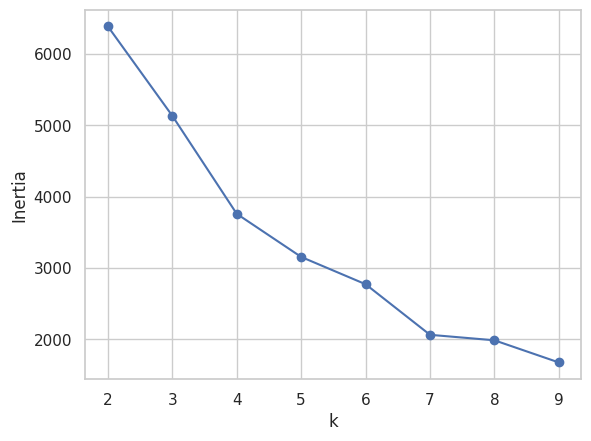

In [20]:
# kmeans클러스터링 : 유클리드 거리 기반으로 그룹을 만듦
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# RFM 스코어만 사용
X = rfm[['R_Score', 'F_Score', 'M_Score']]

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 최적의 k 찾기 (Elbow)
inertia = []
for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()



In [24]:
# 기울기의 변곡점이 k=7 부근에서 나타남 -> 클러스터 수는 7로 판단
# 모델 적용
kmeans = KMeans(n_clusters=7, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

In [25]:
rfm['Cluster'].value_counts()

,count
Cluster,
0,1280
6,735
5,556
4,528
3,505
1,374
2,349


In [26]:
rfm.to_csv("/content/drive/MyDrive/Colab Notebooks/전자상거래_영국 데이터/rfm.csv",index=False)

In [ ]:
# 비교는 파워BI에서 살펴보겠음